In [1]:
import torch
import argparse
import pickle
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import time

def one_hot_encode(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes)

def load_data(data_path, batch_size, num_workers):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
        transforms.RandomRotation(degrees=10),  
        transforms.GaussianBlur(kernel_size=3),  
        transforms.Resize((256, 256)),  
        transforms.ToTensor(),  
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   
    ])

    data_root = data_path
    
    print("Starting to load data...")

    # Create ImageFolder datasets for train, val, and test
    train_dataset = ImageFolder(root=data_root + '/train', transform=transform)
    val_dataset = ImageFolder(root=data_root + '/val', transform=transform)
    test_dataset = ImageFolder(root=data_root + '/test', transform=transform)

    # Create DataLoaders for train, val, and test
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Start a separate thread to display a spinning bar
#     def show_spinner():
#         spinner = ['-', '\\', '|', '/']
#         idx = 0
#         while True:
#             print(f"\rData Loading in Process... {spinner[idx % len(spinner)]}", end="", flush=True)
#             idx += 1
#             time.sleep(0.1)

#     spinner_thread = threading.Thread(target=show_spinner)
#     spinner_thread.daemon = True
#     spinner_thread.start()
    
    class_labels_dict = {class_name: label for label, class_name in enumerate(train_dataset.classes, start=0)}
    reverse_class_labels_dict = {label: class_name for class_name, label in class_labels_dict.items()}
    
    print("\n")
    for class_name in class_labels_dict:
        print(f"{class_name} has Class Index {class_labels_dict[class_name]}\n")

    for data, labels in train_loader:
        one_hot_labels = one_hot_encode(labels, num_classes=25)
            
    print("\nData loading completed.")
            
    return train_loader, val_loader, test_loader

# Example usage:
data_path = "/kaggle/input/data-files/Birds_25/Birds_25"
batch_size = 8
num_workers = 4
train_loader, val_loader,test_loader = load_data(data_path, batch_size, num_workers)


Starting to load data...


Asian-Green-Bee-Eater has Class Index 0

Brown-Headed-Barbet has Class Index 1

Cattle-Egret has Class Index 2

Common-Kingfisher has Class Index 3

Common-Myna has Class Index 4

Common-Rosefinch has Class Index 5

Common-Tailorbird has Class Index 6

Coppersmith-Barbet has Class Index 7

Forest-Wagtail has Class Index 8

Gray-Wagtail has Class Index 9

Hoopoe has Class Index 10

House-Crow has Class Index 11

Indian-Grey-Hornbill has Class Index 12

Indian-Peacock has Class Index 13

Indian-Pitta has Class Index 14

Indian-Roller has Class Index 15

Jungle-Babbler has Class Index 16

Northern-Lapwing has Class Index 17

Red-Wattled-Lapwing has Class Index 18

Ruddy-Shelduck has Class Index 19

Rufous-Treepie has Class Index 20

Sarus-Crane has Class Index 21

White-Breasted-Kingfisher has Class Index 22

White-Breasted-Waterhen has Class Index 23

White-Wagtail has Class Index 24


Data loading completed.


In [2]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class IdentityNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(IdentityNorm, self).__init__()
        self.momentum = momentum
        self.running_mean = 0
        self.running_var = 0
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        shape = (1, self.num_features, 1, 1)
        self.gamma = nn.Parameter(torch.empty(shape))
        self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()

    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        return x


class StandardBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(StandardBatchNorm, self).__init__()
        self.momentum = momentum
        self.running_mean = 0
        self.running_var = 0
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        shape = (1, self.num_features, 1, 1)
        self.gamma = nn.Parameter(torch.empty(shape))
        self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()

    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        if self.training:
            n = x.numel() / x.size(1)
            dimensions = (0, 2, 3)
            var = x.var(dim=dimensions, keepdim=True, unbiased=False)
            mean = x.mean(dim=dimensions, keepdim=True)

            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * (n / (n - 1)) * var + (1 - self.momentum) * self.running_var

        else:
            mean = self.running_mean
            var = self.running_var
        dn = torch.sqrt(var + self.eps)
        x = (x - mean) / dn

        x = x * self.gamma + self.beta

        return x


class InstanceNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNorm, self).__init__()
        self.momentum = momentum
        self.running_mean = 0
        self.running_var = 0
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        shape = (1, self.num_features, 1, 1)


        self.gamma = nn.Parameter(torch.empty(shape))
        self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)


    def forward(self, x):
        N, C, H, W = x.shape

        assert C == self.num_features
        dimensions = (2,3)
        if self.training:
            mean = x.mean(dim=dimensions, keepdim=True)
            var = x.var(dim=dimensions, keepdim=True)
        else:            
            mean = x.mean(dim=dimensions, keepdim=True)
            var = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var + self.eps)
        x = (x - mean)/ dn
        x = x * self.gamma + self.beta

        return x


class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNorm, self).__init__()
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        shape = (1, self.num_features, 1, 1)

        self.gamma = nn.Parameter(torch.empty(shape))
        self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        
        N, C, H, W = x.shape

        assert C == self.num_features
        dimensions = (1,2,3)
        if self.training:
            mean = x.mean(dim=dimensions, keepdim=True)            
            var = x.var(dim=dimensions, keepdim=True)
        else:
            mean = x.mean(dim=dimensions, keepdim=True)            
            var = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var + self.eps)
        x = (x - mean)/ dn

        x = x * self.gamma + self.beta

        return x



class GroupNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, group=4):
        super(GroupNorm,self).__init__()
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.group = group        
        shape = (1, self.num_features, 1, 1)


        self.gamma = nn.Parameter(torch.empty(shape))
        self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        N, C, H, W = x.shape
        assert C % self.group == 0
        assert self.num_features == C

        x = x.view(N, self.group, int(C / self.group), H, W)
        dimensions = (1,2,3)
        mean = x.mean(dim=dimensions, keepdim=True)
        var = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var + self.eps)
        x = (x - mean)/ dn
        x = x.view(N, C, H, W)
        
        x = x * self.gamma + self.beta

        return x

class BatchInstanceNorm(nn.Module):
    def __init__(self, num_features, momentum = 0.1, eps=1e-5, rho=0.5):
        super(BatchInstanceNorm, self).__init__()
        self.momentum = momentum
        self.running_mean = 0
        self.running_var = 0
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.rho = rho
        shape = (1, self.num_features, 1, 1)


        self.gamma = nn.Parameter(torch.empty(shape))
        self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    
    def forward(self, x):
        if self.training:            
                
            n = x.numel() / x.size(1)
            dimensions = (0,2,3)
            var_bn = x.var(dim=dimensions, keepdim=True, unbiased=False)
            mean_bn = x.mean(dim=dimensions, keepdim=True)

            with torch.no_grad():
                
                self.running_mean = self.momentum * mean_bn + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * (n/(n-1)) * var_bn + (1 - self.momentum) * self.running_var

        else:
            mean_bn = self.running_mean
            var_bn = self.running_var
        dn = torch.sqrt(var_bn + self.eps)
        x_bn = (x - mean_bn)/ dn
        dimensions = (2,3)
        mean_in = x.mean(dim=dimensions, keepdim=True)
        var_in = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var_in + self.eps)
        x_in = (x - mean_in)/ dn

        x = self.rho * x_bn + (1-self.rho) * x_in

        x = x * self.gamma + self.beta

        return x

In [3]:
import time 
import torch 
import torch.nn as nn 
import torch.optim as optim 
from tqdm import tqdm 
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt 
# from resnet import ResNet, Block 
import argparse
import pickle
import os 

In [4]:

# from norm import StandardBatchNorm, InstanceNorm, BatchInstanceNorm, LayerNorm, GroupNorm, IdentityNorm


class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1, norm_type='bn'):
        super().__init__()
        self.expansion = 2
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        if norm_type == 'bn' or norm_type== 'inbuilt':
            self.nl1 = StandardBatchNorm(intermediate_channels)
            self.nl2 = StandardBatchNorm(intermediate_channels* self.expansion)
        elif norm_type == 'in':
            self.nl1 = InstanceNorm(intermediate_channels)
            self.nl2 = InstanceNorm(intermediate_channels* self.expansion)
        elif norm_type == 'gn':
            self.nl1 = GroupNorm(num_features=intermediate_channels)  # Assuming a group size of 4
            self.nl2 = GroupNorm(num_features=intermediate_channels* self.expansion)
        elif norm_type == 'bin':
            self.nl1 = BatchInstanceNorm(intermediate_channels)
            self.nl2 = BatchInstanceNorm(intermediate_channels* self.expansion)
        elif norm_type == 'ln':
            self.nl1 = LayerNorm(num_features=intermediate_channels)
            self.nl2 = LayerNorm(num_features=intermediate_channels* self.expansion)
        elif norm_type=='nn':
            self.nl1= IdentityNorm(intermediate_channels)
            self.nl2 = IdentityNorm(intermediate_channels* self.expansion)
        
            
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False)    
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.nl1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.nl2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes, norm_type):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)

        if norm_type == 'bn':
            self.norm = StandardBatchNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'in':
            self.norm = InstanceNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'gn':
            self.norm = GroupNorm(group=4, num_features=16)  # Assuming a group size of 4
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'bin':
            self.norm = BatchInstanceNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'ln':
            self.norm = LayerNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type=='nn':
            self.norm= IdentityNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
        else:
            raise ValueError("Invalid normalization type. Choose from 'batch', 'instance', or 'group'.")
        self.relu = nn.ReLU()
        
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=16, stride=1, norm_type=norm_type)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=32, stride=2, norm_type=norm_type)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=64, stride=2, norm_type=norm_type)
        
        self.avgpool = nn.AdaptiveAvgPool2d((8,8))
        self.fc = nn.Linear(128 * 8*8, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
    
    
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride, norm_type):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 2:
            if norm_type == 'gn':
                num_groups = 4  # Adjust according to your group size preference
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    GroupNorm(num_features=intermediate_channels * 2, group=num_groups),
                )
            elif norm_type == 'bn':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    StandardBatchNorm(intermediate_channels * 2)
                )
            elif norm_type == 'in':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    InstanceNorm(intermediate_channels * 2)
                )
            elif norm_type == 'bin':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    BatchInstanceNorm(intermediate_channels * 2)
                )
            elif norm_type == 'ln':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    LayerNorm(intermediate_channels * 2)
                )
            elif norm_type == 'nn':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    IdentityNorm(intermediate_channels * 2)
                )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride, norm_type))
        self.in_channels = intermediate_channels * 2

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels, norm_type=norm_type))

        return nn.Sequential(*layers)


In [5]:
train_loader

In [6]:
val_loader

In [7]:
import os
from torch.cuda.amp import autocast, GradScaler

In [8]:
import os
def train(model_name, n, batch_size, num_epochs, use_early_stopping, patience, num_classes, opt, lr,norm_type, num_workers,train_loader, val_loader):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)



    num_epochs = num_epochs
    num_classes= num_classes

    def ResNetModel(img_channel=3, num_classes=25, norm_type=norm_type):
        print(f"\nNorm in Train is: {norm_type}\n")
        return ResNet(Block, [n,n,n], img_channel, num_classes, norm_type)


    model = ResNetModel(img_channel=3, norm_type= norm_type,num_classes=25).to(device)
    
#     if torch.cuda.device_count() > 1:
#         print("Using", torch.cuda.device_count(), "GPUs!")
#         model = nn.DataParallel(model)
        
    criterion = nn.CrossEntropyLoss()
    if opt=="SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
    if opt=="AdaGrad":
        optimizer = optim.Adagrad(model.parameters(), lr=lr)
        
    if opt=="RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    if opt=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        
    
    model= model.to(device)
    # Set the number of epochs
    train_losses = []
    train_accuracies = []
    train_micro_f1_scores = []
    train_macro_f1_scores = []
    val_losses = []
    val_accuracies = []
    val_micro_f1_scores = []
    val_macro_f1_scores = []

    # Early stopping parameters
    use_early_stopping = use_early_stopping
    patience = patience 
    early_stopping_counter = 0
    best_val_loss = np.inf
    
    folder_name = f'/kaggle/working/model_name_{model_name}'
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    csv_file_path = os.path.join(folder_name, f'{model_name}_metrics.csv')
    
    with open(csv_file_path, 'w') as f:
        f.write("Epoch,Train Loss,Train Accuracy,Train Micro F1,Train Macro F1,Val Loss,Val Accuracy,Val Micro F1,Val Macro F1\n")
        
    

    # Training loop
    total_start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0
        all_labels = []
        all_predictions = []

        for data, labels in tqdm(train_loader, desc=f'Training - Epoch {epoch + 1}/{num_epochs}', leave=False):
            x = data.to(device)
            y = labels.to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_labels.extend(y.cpu().numpy())
            all_predictions.extend(torch.argmax(y_hat, dim=1).cpu().numpy())

        epoch_train_time = time.time() - epoch_start_time
        average_loss = running_loss / len(train_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        micro_f1 = f1_score(all_labels, all_predictions, average='micro')
        macro_f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f"Train - Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}, Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}, Time: {epoch_train_time:.2f} seconds")

        train_losses.append(average_loss)
        train_accuracies.append(accuracy)
        train_micro_f1_scores.append(micro_f1)
        train_macro_f1_scores.append(macro_f1)

        epoch_val_start_time = time.time()
        model.eval()
        val_running_loss = 0
        val_all_labels = []
        val_all_predictions = []

        with torch.no_grad():
            for val_data, val_labels in tqdm(val_loader, desc=f'Validation - Epoch {epoch + 1}/{num_epochs}', leave=False):
                val_x = val_data.to(device)
                val_y = val_labels.to(device)
                val_y_hat = model(val_x)
                val_loss = criterion(val_y_hat, val_y)
                val_running_loss += val_loss.item()
                val_all_labels.extend(val_y.cpu().numpy())
                val_all_predictions.extend(torch.argmax(val_y_hat, dim=1).cpu().numpy())

        epoch_val_time = time.time() - epoch_val_start_time
        val_average_loss = val_running_loss / len(val_loader)
        val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
        val_micro_f1 = f1_score(val_all_labels, val_all_predictions, average='micro')
        val_macro_f1 = f1_score(val_all_labels, val_all_predictions, average='macro')

        print(f"Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_average_loss:.4f}, Accuracy: {val_accuracy:.4f}, Micro F1: {val_micro_f1:.4f}, Macro F1: {val_macro_f1:.4f}, Time: {epoch_val_time:.2f} seconds")

        val_losses.append(val_average_loss)
        val_accuracies.append(val_accuracy)
        val_micro_f1_scores.append(val_micro_f1)
        val_macro_f1_scores.append(val_macro_f1)

        if use_early_stopping:
            if abs(val_average_loss-best_val_loss) < 1e-5:
                best_val_loss = val_average_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
                break
        
        with open(csv_file_path, 'a') as f:
            f.write(f"{epoch + 1},{average_loss},{accuracy},{micro_f1},{macro_f1},{val_average_loss},{val_accuracy},{val_micro_f1},{val_macro_f1}\n")
            
            
        print(f"File created and saved successfully!!\n")
            
        torch.save(model.state_dict(), f'{folder_name}/{model_name}_model.pth')
        print("Saved Model !!")

    total_train_time = time.time() - total_start_time
    print(f"Total Training Time: {total_train_time / 60:.2f} minutes")





    def plot_with_grid(x, train_data, val_data, train_label, val_label, xlabel, ylabel, title, x_interval=5, folder_name=None):
        plt.figure(figsize=(8, 4))
        plt.plot(x, train_data, label=train_label)
        plt.plot(x, val_data, label=val_label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.xticks(np.arange(min(x), max(x)+1, x_interval))
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        if folder_name is not None:
            os.makedirs(folder_name, exist_ok=True)
            file_path = os.path.join(folder_name, f"{title.replace(' ', '_').lower()}.png")
            plt.savefig(file_path)
        plt.show()

    # Training Loss
    plot_with_grid(range(len(train_losses)), train_losses, val_losses, 'Train', 'Validation', 'Epoch', 'Loss', 'Training and Validation Loss Curves', folder_name=folder_name)

    # Training Accuracy
    plot_with_grid(range(len(train_accuracies)), train_accuracies, val_accuracies, 'Train', 'Validation', 'Epoch', 'Accuracy', 'Training and Validation Accuracy Curves', folder_name=folder_name)

    # Micro F1 Scores
    plot_with_grid(range(len(train_micro_f1_scores)), train_micro_f1_scores, val_micro_f1_scores, 'Train Micro F1', 'Validation Micro F1', 'Epoch', 'F1 Score', 'Micro F1 Score Curves', folder_name=folder_name)

    # Macro F1 Scores
    plot_with_grid(range(len(train_macro_f1_scores)), train_macro_f1_scores, val_macro_f1_scores, 'Train Macro F1', 'Validation Macro F1', 'Epoch', 'F1 Score', 'Macro F1 Score Curves', folder_name=folder_name)
    
    return train_losses, train_accuracies, train_micro_f1_scores,train_macro_f1_scores, val_losses, val_accuracies,val_micro_f1_scores, val_macro_f1_scores

In [9]:
model_name= "n2bs8ep50nc25optAdamlr-3normgnesTpt4"
n =2
batch_size = 8
num_epochs = 50
num_classes = 25
opt = "Adam"
lr = 1e-3
norm_type = "gn"
num_workers = 4
use_early_stopping=  False
patience=4

In [10]:
torch.cuda.empty_cache()

cuda

Norm in Train is: gn



Train - Epoch [1/50], Loss: 2.7590, Accuracy: 0.1611, Micro F1: 0.1611, Macro F1: 0.1543, Time: 401.75 seconds


Validation - Epoch [1/50], Loss: 2.4539, Accuracy: 0.2573, Micro F1: 0.2573, Macro F1: 0.2317, Time: 67.43 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [2/50], Loss: 2.1933, Accuracy: 0.3385, Micro F1: 0.3385, Macro F1: 0.3354, Time: 400.58 seconds


Validation - Epoch [2/50], Loss: 1.9202, Accuracy: 0.4171, Micro F1: 0.4171, Macro F1: 0.4135, Time: 73.15 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [3/50], Loss: 1.8265, Accuracy: 0.4485, Micro F1: 0.4485, Macro F1: 0.4466, Time: 401.21 seconds


Validation - Epoch [3/50], Loss: 1.6151, Accuracy: 0.5142, Micro F1: 0.5142, Macro F1: 0.5185, Time: 65.97 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [4/50], Loss: 1.5604, Accuracy: 0.5305, Micro F1: 0.5305, Macro F1: 0.5300, Time: 400.31 seconds


Validation - Epoch [4/50], Loss: 1.3998, Accuracy: 0.5724, Micro F1: 0.5724, Macro F1: 0.5753, Time: 68.89 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [5/50], Loss: 1.3809, Accuracy: 0.5813, Micro F1: 0.5813, Macro F1: 0.5813, Time: 399.88 seconds


Validation - Epoch [5/50], Loss: 1.2628, Accuracy: 0.6155, Micro F1: 0.6155, Macro F1: 0.6138, Time: 67.13 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [6/50], Loss: 1.2348, Accuracy: 0.6249, Micro F1: 0.6249, Macro F1: 0.6250, Time: 399.36 seconds


Validation - Epoch [6/50], Loss: 1.0831, Accuracy: 0.6685, Micro F1: 0.6685, Macro F1: 0.6705, Time: 63.64 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [7/50], Loss: 1.1322, Accuracy: 0.6572, Micro F1: 0.6572, Macro F1: 0.6577, Time: 400.26 seconds


Validation - Epoch [7/50], Loss: 1.0149, Accuracy: 0.6856, Micro F1: 0.6856, Macro F1: 0.6872, Time: 67.46 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [8/50], Loss: 1.0278, Accuracy: 0.6923, Micro F1: 0.6923, Macro F1: 0.6928, Time: 400.51 seconds


Validation - Epoch [8/50], Loss: 0.9439, Accuracy: 0.7090, Micro F1: 0.7090, Macro F1: 0.7091, Time: 71.38 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [9/50], Loss: 0.9516, Accuracy: 0.7114, Micro F1: 0.7114, Macro F1: 0.7121, Time: 402.17 seconds


Validation - Epoch [9/50], Loss: 0.9229, Accuracy: 0.7158, Micro F1: 0.7158, Macro F1: 0.7196, Time: 71.32 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [10/50], Loss: 0.8774, Accuracy: 0.7314, Micro F1: 0.7314, Macro F1: 0.7320, Time: 400.88 seconds


Validation - Epoch [10/50], Loss: 0.8841, Accuracy: 0.7316, Micro F1: 0.7316, Macro F1: 0.7330, Time: 67.25 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [11/50], Loss: 0.8171, Accuracy: 0.7502, Micro F1: 0.7502, Macro F1: 0.7507, Time: 403.34 seconds


Validation - Epoch [11/50], Loss: 0.7508, Accuracy: 0.7681, Micro F1: 0.7681, Macro F1: 0.7685, Time: 66.19 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [12/50], Loss: 0.7650, Accuracy: 0.7651, Micro F1: 0.7651, Macro F1: 0.7658, Time: 401.88 seconds


Validation - Epoch [12/50], Loss: 0.6652, Accuracy: 0.7920, Micro F1: 0.7920, Macro F1: 0.7918, Time: 69.61 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [13/50], Loss: 0.7095, Accuracy: 0.7801, Micro F1: 0.7801, Macro F1: 0.7806, Time: 401.85 seconds


Validation - Epoch [13/50], Loss: 0.6783, Accuracy: 0.7910, Micro F1: 0.7910, Macro F1: 0.7916, Time: 68.41 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [14/50], Loss: 0.6780, Accuracy: 0.7906, Micro F1: 0.7906, Macro F1: 0.7911, Time: 402.43 seconds


Validation - Epoch [14/50], Loss: 0.6073, Accuracy: 0.8148, Micro F1: 0.8148, Macro F1: 0.8153, Time: 66.51 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [15/50], Loss: 0.6334, Accuracy: 0.8065, Micro F1: 0.8065, Macro F1: 0.8069, Time: 402.02 seconds


Validation - Epoch [15/50], Loss: 0.5575, Accuracy: 0.8272, Micro F1: 0.8272, Macro F1: 0.8282, Time: 66.97 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [16/50], Loss: 0.5911, Accuracy: 0.8167, Micro F1: 0.8167, Macro F1: 0.8172, Time: 400.29 seconds


Validation - Epoch [16/50], Loss: 0.5499, Accuracy: 0.8313, Micro F1: 0.8313, Macro F1: 0.8325, Time: 66.45 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [17/50], Loss: 0.5548, Accuracy: 0.8287, Micro F1: 0.8287, Macro F1: 0.8291, Time: 400.41 seconds


Validation - Epoch [17/50], Loss: 0.5232, Accuracy: 0.8385, Micro F1: 0.8385, Macro F1: 0.8404, Time: 68.95 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [18/50], Loss: 0.5369, Accuracy: 0.8337, Micro F1: 0.8337, Macro F1: 0.8340, Time: 401.54 seconds


Validation - Epoch [18/50], Loss: 0.4580, Accuracy: 0.8567, Micro F1: 0.8567, Macro F1: 0.8573, Time: 66.26 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [19/50], Loss: 0.4979, Accuracy: 0.8447, Micro F1: 0.8447, Macro F1: 0.8451, Time: 400.96 seconds


Validation - Epoch [19/50], Loss: 0.4938, Accuracy: 0.8456, Micro F1: 0.8456, Macro F1: 0.8458, Time: 70.50 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [20/50], Loss: 0.4737, Accuracy: 0.8540, Micro F1: 0.8540, Macro F1: 0.8544, Time: 403.64 seconds


Validation - Epoch [20/50], Loss: 0.4680, Accuracy: 0.8536, Micro F1: 0.8536, Macro F1: 0.8547, Time: 69.38 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [21/50], Loss: 0.4496, Accuracy: 0.8580, Micro F1: 0.8580, Macro F1: 0.8583, Time: 403.61 seconds


Validation - Epoch [21/50], Loss: 0.4080, Accuracy: 0.8713, Micro F1: 0.8713, Macro F1: 0.8724, Time: 70.87 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [22/50], Loss: 0.4281, Accuracy: 0.8657, Micro F1: 0.8657, Macro F1: 0.8660, Time: 404.72 seconds


Validation - Epoch [22/50], Loss: 0.4450, Accuracy: 0.8685, Micro F1: 0.8685, Macro F1: 0.8683, Time: 68.42 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [23/50], Loss: 0.4059, Accuracy: 0.8718, Micro F1: 0.8718, Macro F1: 0.8720, Time: 403.69 seconds


Validation - Epoch [23/50], Loss: 0.3951, Accuracy: 0.8772, Micro F1: 0.8772, Macro F1: 0.8783, Time: 69.62 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [24/50], Loss: 0.3908, Accuracy: 0.8767, Micro F1: 0.8767, Macro F1: 0.8769, Time: 402.03 seconds


Validation - Epoch [24/50], Loss: 0.3753, Accuracy: 0.8846, Micro F1: 0.8846, Macro F1: 0.8851, Time: 71.10 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [25/50], Loss: 0.3774, Accuracy: 0.8826, Micro F1: 0.8826, Macro F1: 0.8828, Time: 402.35 seconds


Validation - Epoch [25/50], Loss: 0.3538, Accuracy: 0.8905, Micro F1: 0.8905, Macro F1: 0.8905, Time: 70.54 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [26/50], Loss: 0.3608, Accuracy: 0.8856, Micro F1: 0.8856, Macro F1: 0.8858, Time: 401.93 seconds


Validation - Epoch [26/50], Loss: 0.3599, Accuracy: 0.8886, Micro F1: 0.8886, Macro F1: 0.8884, Time: 69.62 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [27/50], Loss: 0.3420, Accuracy: 0.8913, Micro F1: 0.8913, Macro F1: 0.8915, Time: 401.68 seconds


Validation - Epoch [27/50], Loss: 0.3265, Accuracy: 0.8992, Micro F1: 0.8992, Macro F1: 0.8998, Time: 66.15 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [28/50], Loss: 0.3203, Accuracy: 0.8985, Micro F1: 0.8985, Macro F1: 0.8987, Time: 401.30 seconds


Validation - Epoch [28/50], Loss: 0.3181, Accuracy: 0.9009, Micro F1: 0.9009, Macro F1: 0.9017, Time: 71.34 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [29/50], Loss: 0.3102, Accuracy: 0.8999, Micro F1: 0.8999, Macro F1: 0.9000, Time: 402.32 seconds


Validation - Epoch [29/50], Loss: 0.2948, Accuracy: 0.9112, Micro F1: 0.9112, Macro F1: 0.9119, Time: 71.79 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [30/50], Loss: 0.3025, Accuracy: 0.9044, Micro F1: 0.9044, Macro F1: 0.9045, Time: 401.83 seconds


Validation - Epoch [30/50], Loss: 0.2729, Accuracy: 0.9154, Micro F1: 0.9154, Macro F1: 0.9154, Time: 69.70 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [31/50], Loss: 0.2845, Accuracy: 0.9100, Micro F1: 0.9100, Macro F1: 0.9100, Time: 401.73 seconds


Validation - Epoch [31/50], Loss: 0.2982, Accuracy: 0.9101, Micro F1: 0.9101, Macro F1: 0.9108, Time: 66.73 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [32/50], Loss: 0.2837, Accuracy: 0.9075, Micro F1: 0.9075, Macro F1: 0.9077, Time: 401.40 seconds


Validation - Epoch [32/50], Loss: 0.2896, Accuracy: 0.9130, Micro F1: 0.9130, Macro F1: 0.9129, Time: 66.03 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [33/50], Loss: 0.2667, Accuracy: 0.9144, Micro F1: 0.9144, Macro F1: 0.9145, Time: 401.87 seconds


Validation - Epoch [33/50], Loss: 0.3004, Accuracy: 0.9100, Micro F1: 0.9100, Macro F1: 0.9102, Time: 66.17 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [34/50], Loss: 0.2628, Accuracy: 0.9165, Micro F1: 0.9165, Macro F1: 0.9166, Time: 401.01 seconds


Validation - Epoch [34/50], Loss: 0.2505, Accuracy: 0.9248, Micro F1: 0.9248, Macro F1: 0.9244, Time: 72.93 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [35/50], Loss: 0.2467, Accuracy: 0.9199, Micro F1: 0.9199, Macro F1: 0.9200, Time: 401.56 seconds


Validation - Epoch [35/50], Loss: 0.2585, Accuracy: 0.9205, Micro F1: 0.9205, Macro F1: 0.9206, Time: 68.04 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [36/50], Loss: 0.2471, Accuracy: 0.9209, Micro F1: 0.9209, Macro F1: 0.9209, Time: 402.26 seconds


Validation - Epoch [36/50], Loss: 0.2702, Accuracy: 0.9142, Micro F1: 0.9142, Macro F1: 0.9145, Time: 65.60 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [37/50], Loss: 0.2399, Accuracy: 0.9253, Micro F1: 0.9253, Macro F1: 0.9254, Time: 401.73 seconds


Validation - Epoch [37/50], Loss: 0.2307, Accuracy: 0.9318, Micro F1: 0.9318, Macro F1: 0.9316, Time: 64.25 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [38/50], Loss: 0.2292, Accuracy: 0.9275, Micro F1: 0.9275, Macro F1: 0.9276, Time: 400.80 seconds


Validation - Epoch [38/50], Loss: 0.2111, Accuracy: 0.9343, Micro F1: 0.9343, Macro F1: 0.9342, Time: 72.30 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [39/50], Loss: 0.2164, Accuracy: 0.9297, Micro F1: 0.9297, Macro F1: 0.9297, Time: 400.93 seconds


Validation - Epoch [39/50], Loss: 0.2152, Accuracy: 0.9363, Micro F1: 0.9363, Macro F1: 0.9364, Time: 72.12 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [40/50], Loss: 0.2155, Accuracy: 0.9310, Micro F1: 0.9310, Macro F1: 0.9310, Time: 402.32 seconds


Validation - Epoch [40/50], Loss: 0.2233, Accuracy: 0.9358, Micro F1: 0.9358, Macro F1: 0.9362, Time: 70.94 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [41/50], Loss: 0.2051, Accuracy: 0.9353, Micro F1: 0.9353, Macro F1: 0.9353, Time: 400.47 seconds


Validation - Epoch [41/50], Loss: 0.1822, Accuracy: 0.9460, Micro F1: 0.9460, Macro F1: 0.9462, Time: 68.30 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [42/50], Loss: 0.2013, Accuracy: 0.9349, Micro F1: 0.9349, Macro F1: 0.9350, Time: 400.74 seconds


Validation - Epoch [42/50], Loss: 0.2004, Accuracy: 0.9380, Micro F1: 0.9380, Macro F1: 0.9380, Time: 68.68 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [43/50], Loss: 0.1921, Accuracy: 0.9398, Micro F1: 0.9398, Macro F1: 0.9398, Time: 401.14 seconds


Validation - Epoch [43/50], Loss: 0.2275, Accuracy: 0.9324, Micro F1: 0.9324, Macro F1: 0.9332, Time: 66.43 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [44/50], Loss: 0.1943, Accuracy: 0.9379, Micro F1: 0.9379, Macro F1: 0.9379, Time: 401.12 seconds


Validation - Epoch [44/50], Loss: 0.2024, Accuracy: 0.9364, Micro F1: 0.9364, Macro F1: 0.9369, Time: 69.51 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [45/50], Loss: 0.1823, Accuracy: 0.9417, Micro F1: 0.9417, Macro F1: 0.9417, Time: 401.51 seconds


Validation - Epoch [45/50], Loss: 0.2111, Accuracy: 0.9382, Micro F1: 0.9382, Macro F1: 0.9386, Time: 64.47 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [46/50], Loss: 0.1761, Accuracy: 0.9429, Micro F1: 0.9429, Macro F1: 0.9429, Time: 400.56 seconds


Validation - Epoch [46/50], Loss: 0.2227, Accuracy: 0.9351, Micro F1: 0.9351, Macro F1: 0.9358, Time: 72.57 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [47/50], Loss: 0.1739, Accuracy: 0.9447, Micro F1: 0.9447, Macro F1: 0.9447, Time: 401.15 seconds


Validation - Epoch [47/50], Loss: 0.2002, Accuracy: 0.9369, Micro F1: 0.9369, Macro F1: 0.9368, Time: 71.30 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [48/50], Loss: 0.1707, Accuracy: 0.9446, Micro F1: 0.9446, Macro F1: 0.9446, Time: 401.17 seconds


Validation - Epoch [48/50], Loss: 0.1795, Accuracy: 0.9451, Micro F1: 0.9451, Macro F1: 0.9453, Time: 69.56 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [49/50], Loss: 0.1668, Accuracy: 0.9458, Micro F1: 0.9458, Macro F1: 0.9458, Time: 401.06 seconds


Validation - Epoch [49/50], Loss: 0.1903, Accuracy: 0.9415, Micro F1: 0.9415, Macro F1: 0.9416, Time: 69.01 seconds
File created and saved successfully!!

Saved Model !!


Train - Epoch [50/50], Loss: 0.1664, Accuracy: 0.9467, Micro F1: 0.9467, Macro F1: 0.9467, Time: 401.02 seconds


Validation - Epoch [50/50], Loss: 0.1602, Accuracy: 0.9542, Micro F1: 0.9542, Macro F1: 0.9542, Time: 67.70 seconds
File created and saved successfully!!

Saved Model !!
Total Training Time: 391.96 minutes


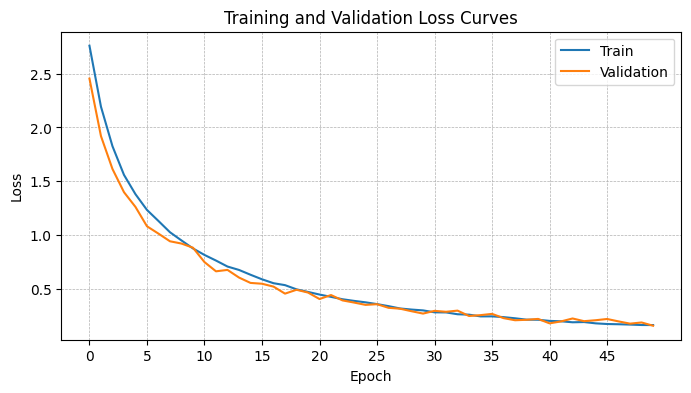

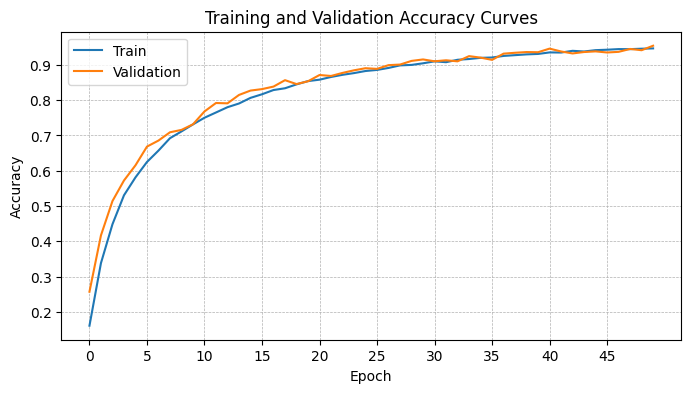

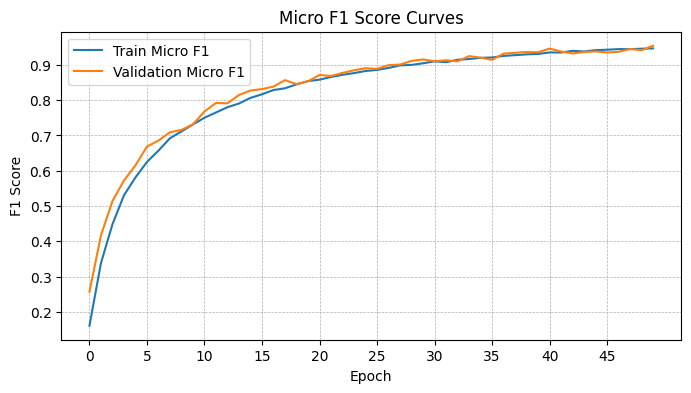

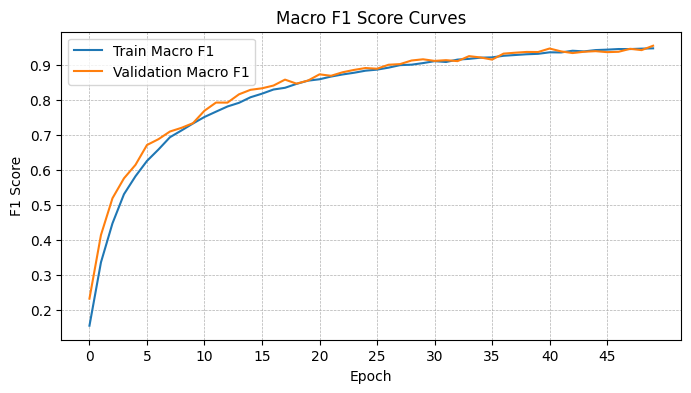

([2.7589653849666567,
  2.193270675833942,
  1.8264770761594102,
  1.560400857330341,
  1.3809341328089946,
  1.2347612124951297,
  1.132179769865111,
  1.0278171038071768,
  0.9515643523142041,
  0.8773921590000634,
  0.8170789883605375,
  0.7649554141167635,
  0.7094648966711073,
  0.6779506912372921,
  0.6334175264304316,
  0.5911250010174823,
  0.5547933682986464,
  0.5369092771497845,
  0.4979133994390458,
  0.47372256041611555,
  0.449554372506804,
  0.42808958029454497,
  0.40591720509413876,
  0.3907980466980129,
  0.37741981223813054,
  0.36080037659556263,
  0.34202274385521886,
  0.32033992150717316,
  0.3102038836403291,
  0.30253306493025295,
  0.284476460288019,
  0.283681732060325,
  0.2666880349516777,
  0.26281299861102897,
  0.2467045885795577,
  0.2471091524254628,
  0.23993714846453226,
  0.22922335760868434,
  0.2163732652238962,
  0.21553273686449578,
  0.20505998796118088,
  0.20129783042328064,
  0.19214899670319333,
  0.1943285238703103,
  0.18227121121335693,


In [11]:
train(model_name, n, batch_size, num_epochs, use_early_stopping, patience, num_classes, opt, lr,norm_type, num_workers,train_loader, val_loader)

In [12]:
# model_name= "n2bs32ep50nc25optSGDlr-4normnnesF"
# n =2
# batch_size = 32
# num_epochs = 50
# num_classes = 25
# opt = "Adam"
# lr = 1e-4
# norm_type = "nn"
# num_workers = 4
# use_early_stopping=  False
# patience=2


In [13]:
# train(model_name, n, batch_size, num_epochs, use_early_stopping, patience, num_classes, opt, lr,norm_type, num_workers,train_loader, val_loader)